# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [3]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [4]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [5]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    plt.savefig("exlettre.png")
    return

On trace la première lettre de X, qui selon Y devrait être un a

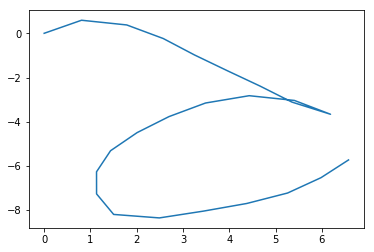

In [6]:
tracerLettre(X[0])

##  Apprentissage d'un modèle CM (max de vraisemblance)
### 1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats`
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [7]:
global N_etats
N_etats = 3  # le nombre d'états avec lequels on dicrétise

In [8]:
def discretise(X, d):
    """
    X : nd.array, d : int -> nd.array
    X : liste des angles
    d : nombre d'etats 
    """
    # Votre code :
    Xp= np.copy(X)
    if d<=0:
        raise ValueError("Nombre d'etats : d >= 1")
    intervalle = 360./d #notre intervallee
    for i in range(len(X)):
        Xp[i] = np.floor(X[i]/intervalle)
    return Xp

In [9]:
Xd = discretise(X, N_etats)

In [10]:
Xd[0]

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [11]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe 

In [18]:
Yl = groupByLabel(Y)

In [19]:
Yl

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),
 array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]),
 array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107]),
 array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147]),
 array([148, 149, 150, 151, 152, 153, 154, 155, 156, 157]),
 array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167]),
 array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177]),
 array([178, 179, 180, 181, 182, 183, 

### 3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [14]:
def ntot(Xc):
    return np.sum([len(x) for x in Xc])

In [15]:
ntot(Xd)

4923

In [16]:
def learnMarkovModel(Xc, d, opt = "zeroes"):
    """
    Xc : nd.array(), d : int, opt = "zeroes" : str -> nd.array(d), nd.array(d, d)
    Xc : base de signaux discrétisés correspondant à une classe C
    d : le nombre d'états
    opt : permet de choisir si on veut initialiser la matrice A à 0 partout("zeroes") ou 1 ("ones")
    """
    # votre code
    
    t = len(Xc) #longueur de la base discretisée
    Pi = np.zeros(d)   #On initialise Pi à 0 dans tout les cas
    if opt == "zeroes":
        A = np.zeros((d, d))    #On remplit A avec des 0
    elif opt == "ones":
        A = np.ones((d, d))     #On remplit A avec des 1
    
    #initilisation de Pi
    unique, counts = np.unique([z[0]for z in Xc], return_counts=True)    #nous permet de compter le nombre d'occurence d'un element en premiere position de chaque ligne
    for i in range(len(unique)):  
        Pi[int(unique[i])] = float(counts[i])/t   #On rajoute dans Pi la proportion de chaque valeur unique
        
    #initilisation de A :     
    for x in Xc:    #On parcourt chaque ligne de notre base
        for i in range(len(x)-1):   #On parcourt chaque angle 
            A[int(x[i]),int(x[i+1])]+=1   #On rajoute la transition correspondante dans A
    
    #Normalisation 
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()
    return Pi, A

In [20]:
#Cette matrice contient toutes les valeurs d'angles pour un tracé de la lettre a, i.e la classe de la lettre a
Xa_d = Xd[Yl[0][0]:Yl[0][len(Yl[0])-1]+1]

In [21]:
Xa_d

array([array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 0.,
       0., 0., 0.]),
       array([0., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       0., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       0., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0.]),
       array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 0., 0.,
       0., 0.]),
 

In [22]:
Pia, Aa = learnMarkovModel(Xa_d, 3) 

In [23]:
Pia

array([0.36363636, 0.        , 0.63636364])

In [24]:
Aa

array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]])

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### 4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [146]:
d = 3                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

In [54]:
models[0]

(array([0.36363636, 0.        , 0.63636364]),
 array([[0.84444444, 0.06666667, 0.08888889],
        [0.        , 0.83333333, 0.16666667],
        [0.11382114, 0.06504065, 0.82113821]]))

In [150]:
Xd[index[0]]

array([array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 0.,
       0., 0., 0.]),
       array([0., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       0., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       0., 0., 0., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0.]),
       array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 0., 0., 0.]),
       array([2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 0., 0.,
       0., 0.]),
 

In [167]:
for cl in range(len(Xa_d)):
    cpt = 0
    if (Xd[index[0]][cl] == Xa_d[cl]).all():
        cpt+=1
        print("True ",cpt)
    else:
        print("Xa_d : ")
        print(Xa_d[cl])
        print("Xd : ")
        print(Xd[cl])

True  1
True  1
True  1
True  1
True  1
True  1
True  1
True  1
True  1
True  1
True  1


##  Test (affectation dans les classes sur critère MV)
### 1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [27]:
def probaSequence(s, Pi, A):
    """
    s : nd.array[int], Pi : nd.array(d)[int], A : nd.array(d, d)[int]  -> float
    """
    # Votre code
    l = np.log(Pi[int(s[0])]) 
    for i in range(0,len(s)-1):    #On itere sur les transitions 
        l+= np.log(A[int(s[i]),int(s[i+1])])
    return l

In [28]:
#Pour avoir l'exemple présenté il faut que l'on itére sur les différentes classes 
#On peut le faire grâce au modele cree precedement
S1_lp = np.array([probaSequence(Xd[0], mods[0], mods[1]) for mods in models])  #Pour chaque modele mods de models on va chercehr Pi et A

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [29]:
S1_lp

array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

In [30]:
np.max((S1_lp[np.isinf(S1_lp)==False]))

-12.482856781808644

Comme on est en Log probabilité on recherche donc la valeur negative qui soit la plus proche de 0, en effet en passant à l'exponentielle elle sera plus grande.

Ici la valeur la plus grande est `-12.48285678180864`donc d'après notre modèle la séquence est classé comme étant cellle d'une lettre "z".

In [31]:
np.log(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

Les `-inf` viennent du fait qu'on fait des logarithmes de valeurs tellement petites que Python les considérent comme des 0.

### 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [32]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [33]:
proba[0:26,0]

array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])

On retrouve bien probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états.

### 3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [307]:
len(Y)

268

In [311]:
Yl

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),
 array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]),
 array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107]),
 array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147]),
 array([148, 149, 150, 151, 152, 153, 154, 155, 156, 157]),
 array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167]),
 array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177]),
 array([178, 179, 180, 181, 182, 183, 

In [320]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
Ynum2 = []
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
for i in range(len(Yl)):
    for j in Yl[i]:
        Ynum2.append(float(i))    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne
print(pred)
# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

[25  0  0  3 25  3  0 25  0  3 25  1  1  1  1  1  1  1  1  1  1  1  2  2
  0  2  2  2  2  2  4  4  2  3  3  3  3  0  3  3  3  0  3  0  4  4  4  4
  4  4  4  3  4  4  4  5  6  6  5 16  6  6  5 16 16 16  6  6  6  6 16 16
  6  6  6  6  6 12  7 24  7  7 13  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9  8  9 10  9  9  8  9  9  9  9  8  8
  8  8  8  8  8  8  8  8 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13
 13 13 13 13  4  4  3 14 14 14  2 14 14 14 15 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 16 22 21 21 13 21 17 20 17 20 21 18 18 18 18
 18 18 18 18 18 18  8  8  8  8  8  8  8  8  8  8 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 20 21 21 21 21 22 22 22 22 22 22 22 22 22 22  8  8
  8  8  8  8  8  8  8  8 24  7 24  3 24 24 24 24 24 24 25 25 25 25 25 25
 25 25 25 25]


0.6902985074626866

In [321]:
print("Ynum : \n", Ynum) 

Ynum : 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 13. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 17. 17.
 17. 17. 17. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 22. 22. 22. 22. 22. 22.
 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 2

In [322]:
print("Ynum2 : \n", np.array(Ynum2)) 

Ynum2 : 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 13. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 17. 17.
 17. 17. 17. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 22. 22. 22. 22. 22. 22.
 22. 22. 22. 22. 23. 23. 23. 23. 23. 23. 

In [323]:
Ynum == Ynum2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [297]:
def procedure(X, Y, d):
    Xd = discretise(X, d)
    index = groupByLabel(Y)
    models = []
    for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel(Xd[index[cl]], d))

    #Calcul des probabilites
    proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))] for cl in range(len(np.unique(Y)))])

    # calcul d'une version numérique des Y :
    Ynum = np.zeros(Y.shape)
    for num, char in enumerate(np.unique(Y)):
        Ynum[Y == char] = num

        
    # Calcul de la classe la plus probable :
    pred = proba.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    return np.where(pred != Ynum, 0.,1.).mean()

In [298]:
procedure(X, Y, 20)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


0.914179104477612

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

On retrouve effectivement les bonnes performances à la fois pour trois états et aussi avec 20 états.

## Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [37]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [231]:
itrain

[array([ 0, 10,  8,  1,  3,  7,  9,  6]),
 array([19, 15, 11, 20, 16, 12, 21, 18]),
 array([32, 26, 25, 31, 23, 24, 29, 28]),
 array([33, 34, 42, 38, 41, 39, 43, 35]),
 array([53, 45, 46, 48, 47, 50, 51, 54]),
 array([55, 57, 59, 56, 62, 64, 61, 63]),
 array([76, 72, 67, 73, 75, 74, 68, 70]),
 array([82, 77, 87, 81, 86, 83, 85, 80]),
 array([95, 93, 91, 94, 90, 89, 97, 96]),
 array([103, 105,  99, 107, 106, 102, 104,  98]),
 array([110, 112, 116, 108, 109, 115, 117, 111]),
 array([119, 127, 126, 125, 121, 124, 118, 120]),
 array([133, 137, 132, 134, 135, 136, 129, 128]),
 array([143, 147, 138, 139, 140, 145, 142, 141]),
 array([152, 155, 156, 154, 157, 150, 148, 149]),
 array([158, 166, 160, 165, 159, 161, 163, 164]),
 array([175, 170, 171, 177, 172, 173, 168, 174]),
 array([178, 184, 185, 183, 182, 181, 186, 180]),
 array([190, 193, 194, 188, 195, 189, 197, 192]),
 array([203, 205, 206, 201, 202, 199, 200, 204]),
 array([209, 212, 217, 211, 210, 216, 208, 215]),
 array([226, 222, 221,

In [368]:
for cl in range(len(np.unique(Y))):
    print("-----------------------------Classe :", cl,"-------------------------------")
    for i in itrain[cl]:
        print("---------------Xd :",i," --------------\n", Xd[i])
        print(Xd[i])

-----------------------------Classe : 0 -------------------------------
---------------Xd : 0  --------------
 [ 2. 19. 17. 17. 17. 17. 17. 18.  7.  9. 11. 12. 12. 13. 14. 15. 16. 19.
  0.  1.  1.  2.  2.]
[ 2. 19. 17. 17. 17. 17. 17. 18.  7.  9. 11. 12. 12. 13. 14. 15. 16. 19.
  0.  1.  1.  2.  2.]
---------------Xd : 10  --------------
 [ 0. 18. 18. 17. 17. 16. 16. 16. 12.  8.  8. 10. 11. 12. 12. 13. 14. 16.
 19.  0.  0.  0.  1.  1.  1.]
[ 0. 18. 18. 17. 17. 16. 16. 16. 12.  8.  8. 10. 11. 12. 12. 13. 14. 16.
 19.  0.  0.  0.  1.  1.  1.]
---------------Xd : 8  --------------
 [19. 17. 16. 16. 16. 16. 15. 11. 10. 11. 12. 13. 14. 16. 19.  0.  0.  1.
  1.]
[19. 17. 16. 16. 16. 16. 15. 11. 10. 11. 12. 13. 14. 16. 19.  0.  0.  1.
  1.]
---------------Xd : 1  --------------
 [18. 17. 17. 16. 16. 16. 16.  7.  8.  9. 10. 11. 11. 12. 13. 15. 17. 18.
 19.  0.  1.]
[18. 17. 17. 16. 16. 16. 16.  7.  8.  9. 10. 11. 11. 12. 13. 15. 17. 18.
 19.  0.  1.]
---------------Xd : 3  --------------
 [17.

In [232]:
itest

[array([2, 4, 5]),
 array([13, 14, 17]),
 array([22, 27, 30]),
 array([36, 37, 40]),
 array([44, 49, 52]),
 array([58, 60, 65]),
 array([66, 69, 71]),
 array([78, 79, 84]),
 array([88, 92]),
 array([100, 101]),
 array([113, 114]),
 array([122, 123]),
 array([130, 131]),
 array([144, 146]),
 array([151, 153]),
 array([162, 167]),
 array([169, 176]),
 array([179, 187]),
 array([191, 196]),
 array([198, 207]),
 array([213, 214]),
 array([219, 223]),
 array([230, 231]),
 array([242, 246]),
 array([251, 255]),
 array([259, 265])]

In [264]:
np.unique(ia)

array([  0,   1,   3,   6,   7,   8,   9,  10,  11,  12,  15,  16,  18,
        19,  20,  21,  23,  24,  25,  26,  28,  29,  31,  32,  33,  34,
        35,  38,  39,  41,  42,  43,  45,  46,  47,  48,  50,  51,  53,
        54,  55,  56,  57,  59,  61,  62,  63,  64,  67,  68,  70,  72,
        73,  74,  75,  76,  77,  80,  81,  82,  83,  85,  86,  87,  89,
        90,  91,  93,  94,  95,  96,  97,  98,  99, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 120,
       121, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 145, 147, 148, 149, 150, 152, 154,
       155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 168, 170,
       171, 172, 173, 174, 175, 177, 178, 180, 181, 182, 183, 184, 185,
       186, 188, 189, 190, 192, 193, 194, 195, 197, 199, 200, 201, 202,
       203, 204, 205, 206, 208, 209, 210, 211, 212, 215, 216, 217, 218,
       220, 221, 222, 224, 225, 226, 227, 228, 229, 232, 233, 23

In [243]:
for cl in range(len(np.unique(Y))):
    print("-----------------------------Classe :", cl,"-------------------------------")
    for i in itest[cl]:
        print("---------------Xd :",i," --------------\n", Xd[i])

-----------------------------Classe : 0 -------------------------------
---------------Xd : 2  --------------
 [19. 18. 17. 17. 18. 17. 17. 17. 10.  9. 10. 11. 12. 13. 13. 15. 16. 18.
  0.  0.  1.  1.  0.]
---------------Xd : 4  --------------
 [ 0. 18. 18. 18. 17. 16. 16. 11. 10. 10. 11. 11. 12. 13. 15. 16. 19.  0.
  0.  0.  0.  1.  0.]
---------------Xd : 5  --------------
 [18. 17. 16. 17. 17. 17. 19.  6.  9. 10. 11. 12. 13. 15. 14. 17. 18.  0.
  1.  1.  2.  2.  1.]
-----------------------------Classe : 1 -------------------------------
---------------Xd : 13  --------------
 [15. 15. 15. 15. 15. 17.  3.  3.  2.  0. 17. 15. 14. 13. 12. 12. 12. 12.]
---------------Xd : 14  --------------
 [15. 15. 15. 14. 15. 15. 14. 15. 18.  3.  5.  5.  4.  3.  0. 19. 19. 17.
 16. 15. 13. 12. 11. 10. 10. 10.]
---------------Xd : 17  --------------
 [15. 15. 15. 15. 14. 15. 15. 15.  1.  5.  4.  4.  4.  3.  1. 19. 18. 16.
 16. 15. 15. 13. 11. 10.  8.  8. 10. 10.]
-----------------------------Classe : 

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

## Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [40]:
# Votre code
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
models_train = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_train.append(learnMarkovModel(Xd[itrain[cl]], d))
    
[probaSequence(Xd[itest[0][0]], mods[0], mods[1]) for mods in models_train]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf]

In [ ]:
proba_Train = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in index[cl]]
                  for cl in range(len(np.unique(Y)))])

In [436]:
def protocole(X, Y, d_max, pas, opt = "zeroes", plot = False, proba = .8):
    D_ = [ d for d in range(1, d_max, pas)]
    ETrain = []
    ETest = []
    itrain, itest = separeTrainTest(Y, proba)
    index = np.array(itrain)
    intest = np.array(itest)
    
    ia = []
    for i in itrain:
        ia += i.tolist()    
    it = []
    for i in itest:
        it += i.tolist()
        
    for d in D_:
        Xd = discretise(X, d)
        
        #Creation des models
        models = []
        for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
            models.append(learnMarkovModel(Xd[index[cl]], d, opt))

        #Calcul des probabilites
        Xd_Train = []
        for i in ia: 
            Xd_Train.append(Xd[i])
        proba_Train = np.array([[probaSequence(Xd_Train[i], models[cl][0], models[cl][1]) for i in range(len(ia))]
                  for cl in range(len(np.unique(Y)))])
        
        Xd_Test = []
        for i in it: 
            Xd_Test.append(Xd[i])
        proba_Test = np.array([[probaSequence(Xd_Test[i], models[cl][0], models[cl][1]) for i in range(len(it))]
                  for cl in range(len(np.unique(Y)))])
        
            
        # calcul d'une version numérique des Y :
        iTrain_num = []    
        for i in range(len(index)):
            for j in index[i]:
                iTrain_num.append(float(i)) 
                
        iTest_num = []    
        for i in range(len(intest)):
            for j in intest[i]:
                iTest_num.append(float(i)) 
        
        # Calcul de la classe la plus probable :
        pred_Train = proba_Train.argmax(0) # max colonne par colonne
        pred_Test = proba_Test.argmax(0)
        
        # Calcul d'un pourcentage de bonne classification :
        ETrain.append (np.where(pred_Train != iTrain_num, 0.,1.).mean())
        ETest.append (np.where(pred_Test != iTest_num, 0.,1.).mean())
        
    if plot == True:
        plt.plot(D_, ETrain, color= 'green', label = "Apprentissage") 
        plt.plot(D_, ETest, color= 'red', label = "Test") 
        plt.gca().legend().set_visible(True)
        plt.title("Base de test sur les performances Train v. Test")
        plt.xlabel("$d$ : discretisation")
        plt.ylabel("Indice de performance (en %)")
        plt.show() 
    return ETrain, ETest

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


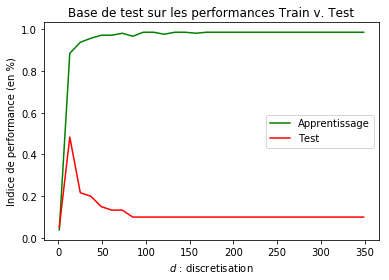

([0.038461538461538464,
  0.8846153846153846,
  0.9375,
  0.9567307692307693,
  0.9711538461538461,
  0.9711538461538461,
  0.9807692307692307,
  0.9663461538461539,
  0.9855769230769231,
  0.9855769230769231,
  0.9759615384615384,
  0.9855769230769231,
  0.9855769230769231,
  0.9807692307692307,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231,
  0.9855769230769231],
 [0.05,
  0.48333333333333334,
  0.21666666666666667,
  0.2,
  0.15,
  0.13333333333333333,
  0.13333333333333333,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1])

In [427]:
protocole(X,Y, 360, 12, plot = True)

## Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

Pou cela j'ai déjà implémenté dans les fonctions précédentes une option qui permet de choisir si on veut créer une matrice Pi remplie avec des 1 au début.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


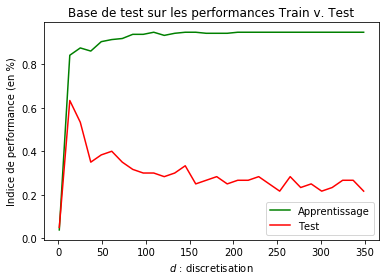

In [441]:
P_Train, P_Test = protocole(X,Y, 360, 12, opt = "ones", plot = True)

In [449]:
np.argmax(P_Test)

1

Dans tout les cas, on pet voir qu'il y a un seuil de discretisation optimale. Passé ce seuil l'indice de performance diminue fortement. Ici in peut voir que cest pour 2 classes. Car les classes commencent à 1.

In [445]:
def Opt_separation(X, Y, d_max, pas, ETrain, ETest, opt = "ones", plot = True):
    P = np.arange(0.1, 1, .1)
    D_max = {}
    for p in P:
        E_Train, E_Test = protocole(X, Y, 360, 12, opt = "ones", plot = True, proba = p)
        dmax = np.argmax(E_Test)
        D_max[p] = (dmax, E_Test[dmax])
    return D_max

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


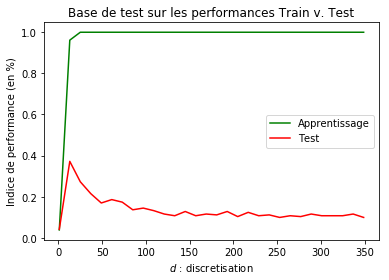

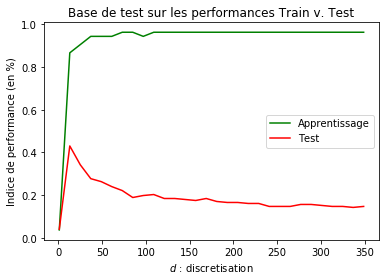

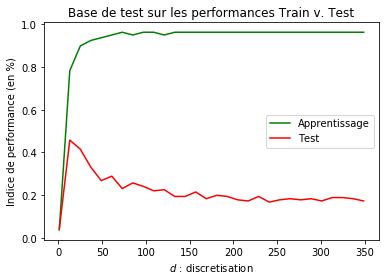

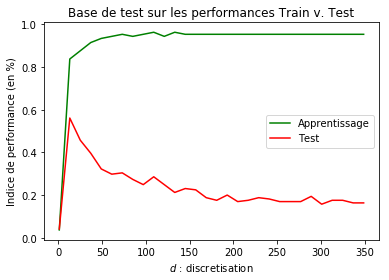

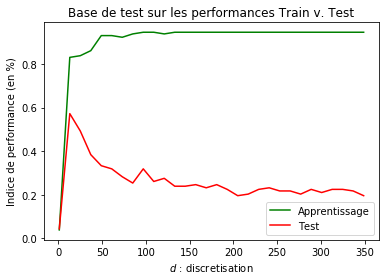

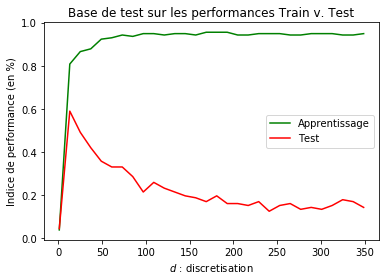

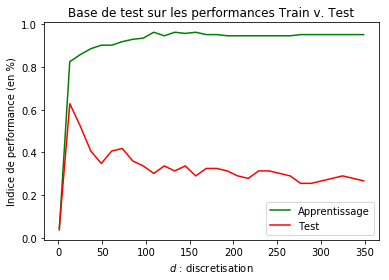

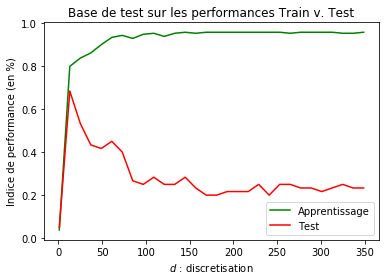

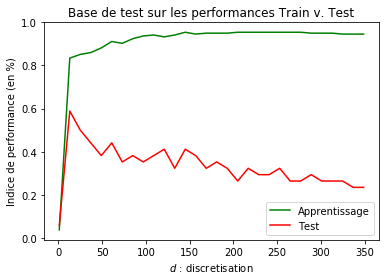

{0.1: (1, 0.371900826446281),
 0.2: (1, 0.4305555555555556),
 0.30000000000000004: (1, 0.45789473684210524),
 0.4: (1, 0.5609756097560976),
 0.5: (1, 0.572463768115942),
 0.6: (1, 0.5892857142857143),
 0.7000000000000001: (1, 0.627906976744186),
 0.8: (1, 0.6833333333333333),
 0.9: (1, 0.5882352941176471)}

In [446]:
Opt_separation(X, Y, 360, 12, P_Train, P_Test, opt = "ones", plot = True)

On a effectivement un meilleur ration avec une telle separation de nos jeux de données. Et surtout le maximum est toujours réalisé pour deux classes. Il n'y a donc que deux classes significatives dans ce jeu de données. On pourrait réaliser une ACP ou une classification pour aller plus loin.

# Partie optionnelle
## Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [ ]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [ ]:
# Votre code

- Tracé de la matrice : 

In [ ]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres.png")

## Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [ ]:
# Votre code

### Affichage du résultat

In [ ]:
newa = generate(models[0][0], models[0][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)